In [1]:
import torch
import torchvision.transforms.functional as F

from PIL import Image

import pandas as pd

import numpy as np

import pickle

import os

from tqdm import tqdm

from models import UNet

/home/kdhsimplepro/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Preprocessing

In [2]:
label_frame = pd.read_csv("../data/label_frame.csv")
label_frame.head()

,file,"forehead (0, 1, 2)","length (0, 1, 2, 3, 4)"
0,0.jpg,2,NaN
1,1.jpg,2,NaN
2,2.jpg,2,NaN
3,3.jpg,2,NaN
4,4.jpg,2,NaN


In [3]:
label_frame = label_frame.to_numpy().tolist()
print(label_frame[:3])

[['0.jpg', '2', nan], ['1.jpg', '2', nan], ['2.jpg', '2', nan]]


In [4]:
with open("../data/male_path_to_celeba_path.pickle", "rb") as f:
    male_path_to_celeba_path = pickle.load(f)

In [5]:
model = UNet().to("cuda")
model.eval()
model.load_state_dict(torch.load("./best_params.pth"))

<All keys matched successfully>

In [6]:
latent_codes = {
    "0": [], # (이마 약간이라도 가림)
    "1": [] # (이마 다 보임)
}

In [7]:
for male_path, forehead, length in tqdm(label_frame):
    img = Image.open(os.path.join("../data", "male", male_path)).convert("RGB").resize((256, 256))
    img = F.to_tensor(img).to("cuda").unsqueeze(0)

    latent_code = img

    for i in range(len(model.encoder)):
        latent_code = model.encoder[i](latent_code)

    latent_code = model.center[0](latent_code)

    if type(forehead) != float and not pd.isnull(forehead):
        if forehead in ["0", "1"]:
            latent_codes["0"].append((male_path, latent_code.squeeze(0).view(-1).cpu().detach()))

        elif forehead == "2":
            latent_codes["1"].append((male_path, latent_code.squeeze(0).view(-1).cpu().detach()))

100%|██████████| 7443/7443 [00:30<00:00, 245.74it/s]


In [8]:
len(latent_codes["0"]), len(latent_codes["1"])

(171, 456)

In [9]:
latent_codes_tensor = torch.stack((*[code[1] for code in latent_codes["0"]], *[code[1] for code in latent_codes["1"]]), dim=0)
latent_codes_tensor.shape

torch.Size([627, 8192])

#### Visualization(PCA) & Analysis 

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(latent_codes_tensor.numpy())

StandardScaler()

In [11]:
scaled_codes = scaler.transform(latent_codes_tensor.numpy())
print(scaled_codes.shape)

(627, 8192)


In [12]:
scaled_codes[0]

array([-1.745731  , -0.58729696, -0.75628483, ..., -0.5954897 ,
       -0.7983814 ,  5.997611  ], dtype=float32)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(scaled_codes)

decomposed_codes = pca.transform(scaled_codes)

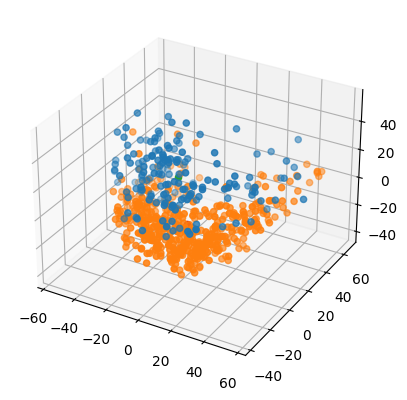

In [14]:
import matplotlib.pyplot as plt

ax = plt.figure().add_subplot(projection="3d")
ax.scatter(decomposed_codes[:171, 0], decomposed_codes[:171, 1], decomposed_codes[:171, 2], label="forehead 0, 1")
ax.scatter(decomposed_codes[171:, 0], decomposed_codes[171:, 1], decomposed_codes[171:, 2], label="forehead 2")
ax.scatter(decomposed_codes[:171, 0].mean(), decomposed_codes[:171, 1].mean(), decomposed_codes[:171, 2].mean(), label="forehead 0, 1 proto")
ax.scatter(decomposed_codes[171:, 0].mean(), decomposed_codes[171:, 1].mean(), decomposed_codes[171:, 2].mean(), label="forehead 2 proto")

In [15]:
proto0 = torch.mean(latent_codes_tensor[:171], dim=0)
proto1 = torch.mean(latent_codes_tensor[171:], dim=0)

pred = torch.zeros((627, 1))
print(proto0.shape, proto1.shape, pred.shape)

torch.Size([8192]) torch.Size([8192]) torch.Size([627, 1])


In [16]:
dis0 = ((latent_codes_tensor - proto0)**2).sum(dim=1)
dis1 = ((latent_codes_tensor - proto1)**2).sum(dim=1)

print(dis0.shape, dis1.shape)

torch.Size([627]) torch.Size([627])


In [17]:
pred = (dis0 > dis1).type(torch.long) # 0: forehead 0, 1, 1: forehead 2
print((pred[:171] == 0).sum())
print((pred[171:] == 1).sum())

tensor(144)
tensor(427)


In [18]:
print(((pred[:171] == 0).sum() + (pred[171:] == 1).sum()) / len(pred))

tensor(0.9107)


In [19]:
data = torch.abs(dis0 - dis1)
print(data.mean(), data.std())

tensor(310.7068) tensor(180.6161)


In [20]:
wrong0 = data[:171][pred[:171] == 1]
print(wrong0.mean(), wrong0.std())

tensor(135.4289) tensor(86.8148)


In [21]:
wrong1 = data[171:][pred[171:] == 0]
print(wrong1.mean(), wrong1.std())

tensor(125.1619) tensor(121.3334)


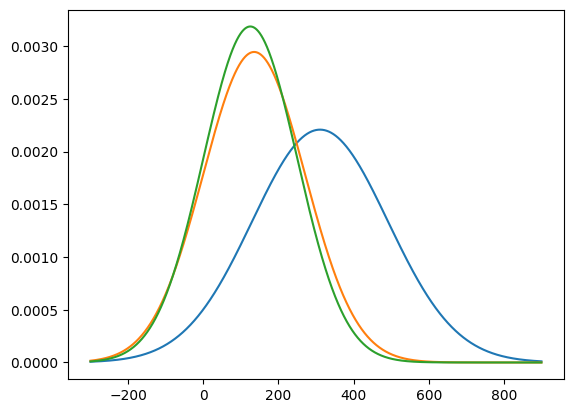

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import norm

x = np.arange(-300, 900, 0.1)
plt.plot(x, norm.pdf(x, loc=data.mean().item(), scale=data.std().item()), label="data distribution")
plt.plot(x, norm.pdf(x, loc=wrong0.mean().item(), scale=wrong0.mean().item()), label="wrong0 distribution")
plt.plot(x, norm.pdf(x, loc=wrong1.mean().item(), scale=wrong1.mean().item()), label="wrong1 distribution")
plt.show()

In [23]:
wrong_data = sorted(wrong0.tolist() + wrong1.tolist())

In [24]:
is_wrong = torch.tensor((pred[:171] == 1).tolist() + (pred[171:] == 0).tolist()).type(torch.long)

In [25]:
is_wrong.shape, data.shape

(torch.Size([627]), torch.Size([627]))

In [26]:
mat = torch.concat((data.unsqueeze(1), is_wrong.unsqueeze(1)), dim=1)
print(mat.shape)

torch.Size([627, 2])


In [27]:
mat = mat.tolist()
mat = sorted(mat, key=lambda x: x[0])

In [28]:
data_n = len(mat)
wrong_n = len(wrong0) + len(wrong1)

for i in range(len(mat)):
    d, is_w = mat[i]

    data_n -= 1
    wrong_n -= is_w

    if wrong_n / data_n <= 0.01:
        break

threshold = d
print(f"threshold: {threshold}")

threshold: 301.4039306640625


In [29]:
acc = []

for i in range(171):
    if data[i] > threshold:
        acc.append(pred[i] == 0)

for i in range(171, len(pred)):
    if data[i] > threshold:
        acc.append(pred[i] == 1)

print(len(acc))     

307


In [30]:
sum(acc) / len(acc) * 100

tensor(99.0228)

### Labeling

In [31]:
class LabelingTool:

    def __init__(self):
        self.proto0 = torch.mean(latent_codes_tensor[:171], dim=0).to("cuda")
        self.proto1 = torch.mean(latent_codes_tensor[171:], dim=0).to("cuda")

        self.threshold = threshold

    @torch.no_grad()
    def get_latent_code(self, img: torch.tensor) -> torch.tensor:

        if img.ndim == 3: latent_code = img.unsqueeze(0)
        elif img.ndim == 4: latent_code = img

        for i in range(len(model.encoder)):
            latent_code = model.encoder[i](latent_code)

        latent_code = model.center[0](latent_code).view(-1)

        return latent_code

    @torch.no_grad()
    def get_distance(self, latent_code: torch.tensor):
        dis0 = ((latent_code - self.proto0)**2).sum()
        dis1 = ((latent_code - self.proto1)**2).sum()

        return dis0, dis1

    @torch.no_grad()
    def predict(self, img: torch.tensor):
        latent_code = self.get_latent_code(img)
        dis0, dis1 = self.get_distance(latent_code)
        confidence = torch.abs(dis0 - dis1)

        if confidence > self.threshold:
            return (dis0 > dis1).type(torch.long).cpu().detach().item()  # 0 -> forehead 0, 1 -> forehead 1
    
        return None

In [32]:
labeling_tool = LabelingTool()

In [33]:
with open("../data/celeba_male_number.pickle", "rb") as f:
    celeba_male_number = pickle.load(f)

with open("../data/ffhq_male_number.pickle", "rb") as f:
    ffhq_male_number = pickle.load(f)

print(len(celeba_male_number), len(ffhq_male_number))

7443 32170


In [34]:
celeba_cnt = 0

for celeba_num in tqdm(celeba_male_number):
    img_path = os.path.join("../data", "CelebAMask-HQ", "CelebA-HQ-img", f"{celeba_num}.jpg")
    img = F.to_tensor(Image.open(img_path).convert("RGB").resize((256, 256))).to("cuda")
    
    pred = labeling_tool.predict(img)

    if pred != None:
        F.to_pil_image(img).save(os.path.join("../data", "StarGAN_dataset", "forehead", str(pred), f"{celeba_num}.jpg"))
        celeba_cnt += 1

100%|██████████| 7443/7443 [00:58<00:00, 126.29it/s]


In [35]:
ffhq_cnt = 0

for ffhq_num in tqdm(ffhq_male_number[10030:]):
    img_path = os.path.join("../data", "ffhq128", "{:05d}.png".format(ffhq_num))
    img = F.to_tensor(Image.open(img_path).convert("RGB").resize((256, 256))).to("cuda")
    
    pred = labeling_tool.predict(img)

    if pred != None:
        F.to_pil_image(img).save(os.path.join("../data", "StarGAN_dataset", "forehead", str(pred), "{:05d}.png".format(ffhq_num)))
        ffhq_cnt += 1

100%|██████████| 22140/22140 [01:58<00:00, 186.63it/s]
